In [9]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

In [10]:
from pymatgen.io.cif import CifParser,CifWriter
import numpy as np
from pymatgen.core import Lattice

def transform(a_reduce=0.87,angle=-180,phi=0,move=0.93):
    parser = CifParser("../data/dipoles1.cif")
    structure = parser.get_structures()[0]
    coord = structure.cart_coords[3]+structure.cart_coords[5]+structure.cart_coords[6]+structure.cart_coords[8]
    coord=coord/4
    coord[2]=coord[2]*move
    new_a=structure.lattice.a*a_reduce

    structure.rotate_sites([3,5,6,8],np.deg2rad(angle),[0,1,0],coord)
    
    structure.rotate_sites([3,5,6,8],np.deg2rad(phi),[1,0,0],coord)
    structure

    #print structure
    lattice = Lattice.from_parameters(a=new_a, b=structure.lattice.b, c=structure.lattice.c, alpha=90,
                                      beta=structure.lattice.beta, gamma=90)
    # structure.modify_lattice(lattice)
    structure.lattice = lattice
    return structure

def get_mean_distance(structure):
    k=6
    val1=[]
    val2=[]
    dist1=[]
    dist2=[]
    for i in structure.get_neighbors(structure[2],10):
            if i[0].species_string=="Cl":
                dist1.append(i[1])
    val1.append(np.sort(dist1)[:k])
    for i in structure.get_neighbors(structure[3],10):
            if i[0].species_string=="Cl":
                dist2.append(i[1])
    val2.append(np.sort(dist2)[:k])
    return np.mean([val1,val2])

def get_mean_distance_angle(theta,phi):
    structure=transform(a_reduce=1,angle=theta,phi=phi,move=1)
    return get_mean_distance(structure)

In [11]:
def create_spehircal_mesh_points(n):
    t=np.linspace(0,np.rad2deg(2*np.pi),n)
    p=np.linspace(0,np.rad2deg(np.pi),n)
    return t,p

In [4]:
nk=41
t,p=create_spehircal_mesh_points(nk)
angles_distance=np.array([get_mean_distance_angle(theta=i,phi=j) for i in t for j in p]).reshape(nk,nk)
# angles_distance=pickle.load(open("../data/angles_nn_distance.pickle", "rb"))

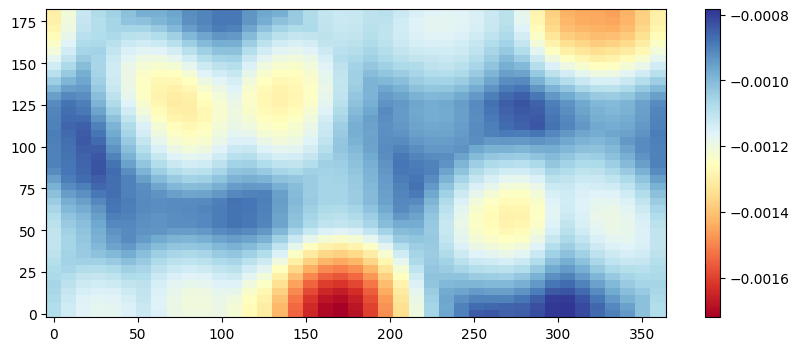

In [5]:
LJpotential=lambda eps,r0: eps*((r0/angles_distance)**12 - (r0/angles_distance)**6)
fig,ax=plt.subplots(1,1,figsize=(10,4))
plt.pcolor(t,p,LJpotential(1,1).T,cmap="RdYlBu",shading="auto")
plt.colorbar()


In [6]:
import sys;sys.path.append("../")
from utils import get_U_equation
import sympy as sp
Uz_symbolic,[t1,p1,t2,p2]=get_U_equation('z')
P1={t1:0,p1:0} #Spin 1 pointing along z axis
Uz=sp.lambdify((t2,p2),Uz_symbolic.subs(P1))
dipole_z=np.array([Uz(j,i) for i in np.deg2rad(p) for j in np.deg2rad(t)]).reshape(nk,nk)

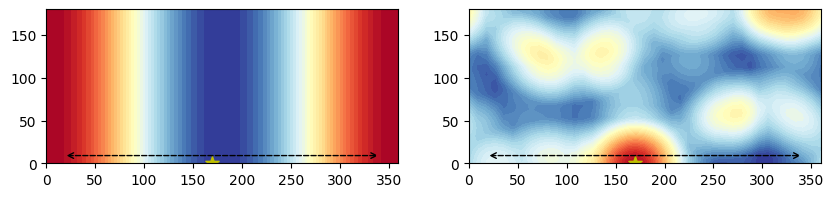

In [7]:
import matplotlib.patches as patches
p1 = patches.FancyArrowPatch((0, 0), (0, 1), arrowstyle='->', mutation_scale=20)

fig,ax=plt.subplots(1,2,figsize=(10,2))


ax[0].contourf(t,p,dipole_z,40,cmap="RdYlBu",vmin=-2,vmax=2)
ax[1].contourf(t,p,LJpotential(1,1).T,50,cmap="RdYlBu")

for i in ax:
    i.annotate('', xy=(.95, 0.05), xycoords='axes fraction', xytext=(.05, 0.05), 
            arrowprops=dict(arrowstyle="<->", color='k',lw=1,ls="--"))
    i.scatter(170,0,s=100,marker="*",color="y")

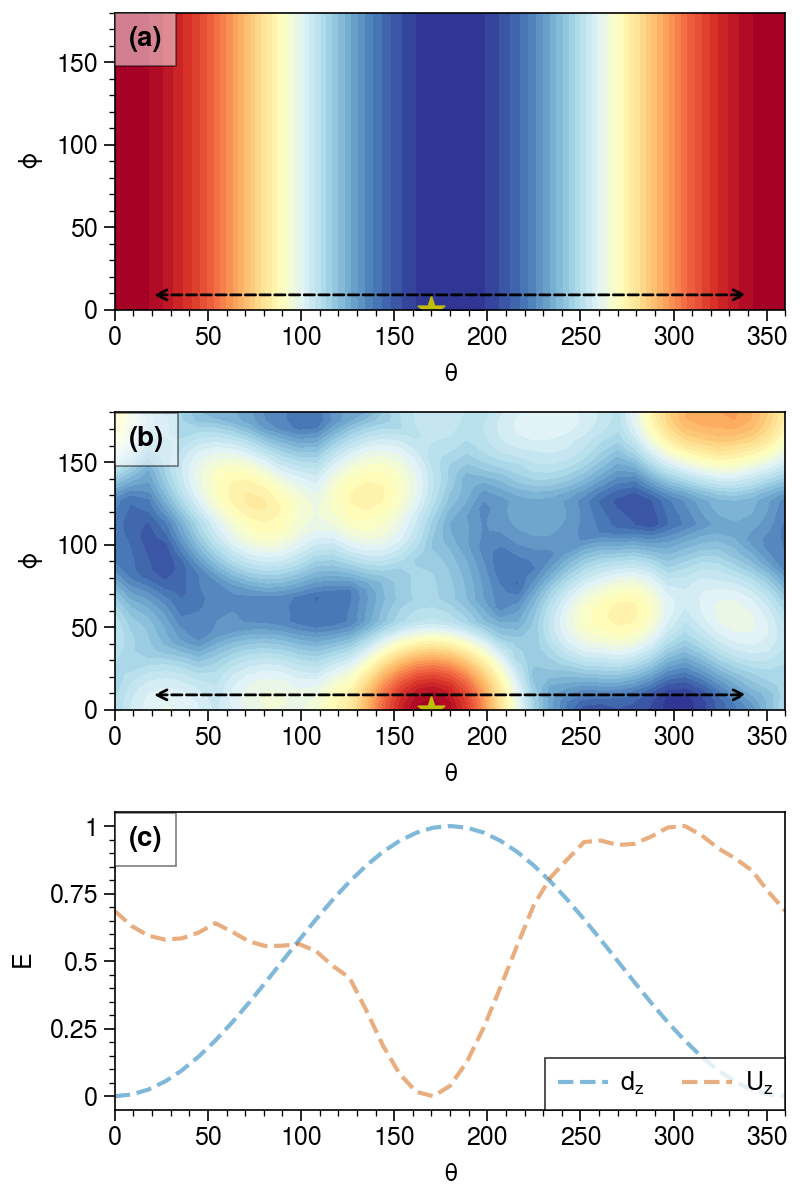

In [24]:
import proplot as pplt
pplt.rc.reset()
pplt.rc.update(grid=False, titleloc='uc')
fig, ax = pplt.subplots([[1],[2],[3]],share=False,figsize=(4,6))
fig.patch.set_facecolor('w')
ax.format(
    abc='(a)', abcloc='upper left',abcbbox=True
)

ax[0].contourf(t,p,dipole_z,cmap="RdYlBu",N=40)
ax[:2].format(ylabel="$\\phi$")
ax[1].contourf(t,p,LJpotential(1,1).T,cmap="RdYlBu",N=40)
ax[:2].format(xlabel="$\\theta$")

def min_max_scale(data):
    return (data-np.min(data))/(np.max(data)-np.min(data))

ax[2].plot(t,min_max_scale(dipole_z[0]),label="$d_z$",alpha=0.5,ls="--")
ax[2].plot(t,min_max_scale(LJpotential(1,1).T[0]),label="$U_z$",alpha=0.5,ls="--")
ax[2].legend(loc="lower right")
ax[2].format(xlabel="$\\theta$",ylabel="$E$")
for i in ax[:2]:
    i.annotate('', xy=(.95, 0.05), xycoords='axes fraction', xytext=(.05, 0.05), 
            arrowprops=dict(arrowstyle="<->", color='k',lw=1,ls="--"))
    i.scatter(170,0,s=100,marker="*",color="y")
